### Load Dependencies

In [ ]:
%pip install opendatasets

### Imports

In [26]:
import h5py
import os
import numpy as np
import opendatasets as od
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from utils import ProgressBar, plot_metrics

### Load Dataset

In [ ]:
# Download Kaggle dataset (Kaggle username and key is required)
# {"username":"christopherconroy","key":"1915e76943ae798bc236fb7c2de6d28d"}
od.download('https://www.kaggle.com/datasets/grassknoted/asl-alphabet')

In [ ]:
# Constants
TEST_DATA_DIR = 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'
TRAIN_DATA_DIR = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'
SEED = 0

In [ ]:
# Seed PyTorch
torch.manual_seed(SEED)

# Initialize dataset
dataset = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_DIR,
    transform=ToTensor()
)
num_inputs = np.array(dataset[0][0].numpy().shape).prod()
num_outputs = len(dataset.classes)

# Check for CUDA GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

In [ ]:
# Get sample dimensions
dataset[0][0].size()

In [ ]:
def split_dataset(dataset, num_samples, train_split, batch_size, seed=0):
    '''
    Create training and test data loaders from the given dataset.

    Params:
        dataset = PyTorch Dataset instance for full dataset
        num_samples = Number of samples to use from the full dataset
        train_split = Fraction of train data in train/test split
        batch_size Minibatch size for training
        seed = Random seed for dataset shuffle and split. Set to None for no seed.

    Returns:
        train_loader = Dataloader for the training samples
        test_loader = Dataloader for the test samples
    '''

    # Perform stratified split of dataset indicies
    train_size = int((num_samples * train_split) // batch_size) * batch_size
    test_size = num_samples - train_size
    dataset_inds = list(range(len(dataset)))
    train_inds, test_inds = train_test_split(dataset_inds, train_size=train_size, 
            test_size=test_size, random_state=seed, stratify=dataset.targets)

    # Create training and test subsets
    train_set = Subset(dataset, train_inds)
    test_set = Subset(dataset, test_inds)

    # Initialize data loader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

### Training Implementation

In [ ]:
def train(data_loader, model, loss_func, optimizer, conv):
    # Initialize parameters
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    total_loss = 0
    correct = 0

    # Set mode to training
    model.train()

    # Initialize progress bar
    progress = ProgressBar('Train Progress', len(data_loader))

    # Iterate through batches
    for images, labels in data_loader: 
        # Transfer images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        if not conv:
            images = images.view(-1, num_inputs)
        
        # Forward pass 
        outputs = model(images)
        loss = loss_func(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Optimization
        optimizer.step()

        # Transfer outputs and labels to CPU
        outputs, labels = outputs.cpu(), labels.cpu()
        
        # Compute batch metrics
        total_loss += loss.item()
        pred = torch.max(outputs, 1)[1]
        correct += (pred == labels).sum().numpy()

        # Update progress
        progress.step()

    # Compute metrics for dataset
    total_loss /= num_batches
    accuracy = (correct / size) * 100

    return total_loss, accuracy

In [ ]:
def test(data_loader, model, loss_func, conv):
    # Initialize parameters
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    total_loss = 0
    correct = 0

    # Set mode to evaluation
    model.eval()

    # Initialize progress bar
    progress = ProgressBar('Valid Progress', len(data_loader))

    # Iterate through batches
    with torch.no_grad():
        for images, labels in data_loader:
            # Transfer images and labels to GPU
            images, labels = images.to(device), labels.to(device)
            if not conv:
                images = images.view(-1, num_inputs)

            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Transfer outputs and labels to CPU
            outputs, labels = outputs.cpu(), labels.cpu()

            # Compute batch metrics
            total_loss += loss.item()
            pred = torch.max(outputs, 1)[1]
            correct += (pred == labels).sum().numpy()

            # Update progress
            progress.step()
            
    # Compute metrics for dataset
    total_loss /= num_batches
    accuracy = (correct / size) * 100

    return total_loss, accuracy

In [ ]:
def train_model(model, train_loader, valid_loader, learning_rate, num_epochs, weight_decay=0, conv=False):
    # Initialize training parameters
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize metrics
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []

    # Train model
    for epoch in range(num_epochs):
        # Train and evaluate model
        train_loss, train_accuracy = train(train_loader, model, loss_func, optimizer, conv)
        valid_loss, valid_accuracy = test(valid_loader, model, loss_func, conv)

        # Store epoch metrics
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(valid_loss)
        test_accuracy_list.append(valid_accuracy)

        # Output progress
        print('Epoch {} | Loss = {:.4f} | Train Accuracy = {:.2f}% | Test Accuracy = {:.2f}%'
            .format(epoch + 1, train_loss, train_accuracy, valid_accuracy))

    return (train_loss_list, train_accuracy_list), (test_loss_list, test_accuracy_list)

### Model #1 - MLP

This simple model is used to verify that the supporting data loading, splitting, training and validation functions are working correctly by training the model on a small subset of the data. The model metrics should show distinct decreasing loss and attain a high training accuracy.

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.hidden1 = nn.Linear(num_inputs, 1000)
        self.hidden2 = nn.Linear(1000, 200)
        self.output = nn.Linear(200, num_outputs)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)
        return x

model1 = Net1()
model1 = model1.to(device)

In [ ]:
train_loader1, valid_loader1 = split_dataset(dataset, 58, 0.5, 29, SEED)
train_metrics1, valid_metrics1 = train_model(model1, train_loader1, valid_loader1, 5e-4, 100)

In [ ]:
plot_metrics(train_metrics1, valid_metrics1)

### Model #2 - Base CNN

This model is a simple CNN used to verify that such an architecture is able to train on the data and provide baseline performance. The architecture is based on the baseline model used in this [paper](https://ieeexplore.ieee.org/document/8392660) but does not make use of dropout layers or any other form of regularization.

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        # self.dropout1 = nn.Dropout2d(0.2)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # self.dropout2 = nn.Dropout2d(0.2)

        # Fully connected layer 1
        self.fc1 = nn.Linear(32 * 50**2, 128)
        # self.dropout3 = nn.Dropout2d(0.2)

        # Fully connected layer 2
        self.fc2 = nn.Linear(128, 64)
        # self.dropout4 = nn.Dropout2d(0.2)

        # Output layer
        self.fc3 = nn.Linear(64, 29)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model2 = Net2()
model2 = model2.to(device)

In [ ]:
from torchsummary import summary
summary(model2, input_size=(3, 200, 200))

In [ ]:
train_loader2, valid_loader2 = split_dataset(dataset, 87000, 0.8, 100, SEED)
train_metrics2, valid_metrics2 = train_model(model2, train_loader2, valid_loader2, 5e-4, 10, conv=True)

Final Train Accuracy = 98.70%
Final Test Accuracy  = 98.39%


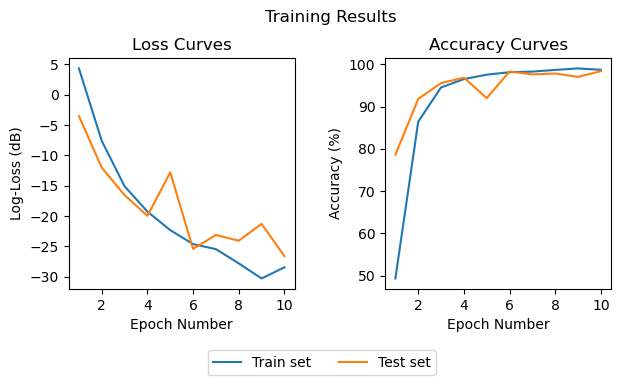

In [37]:
plot_metrics(train_metrics2, valid_metrics2)